## Consegna
Il giro del mondo in 80 giorni

Consideriamo il dataset che descrive alcune delle principali città del mondo. Supponiamo che sia sempre possibile viaggiare da ciascuna città alle 3 città più vicine e che tale viaggio richieda 2 ore per la città più vicina, 4 ore per la seconda città più vicina e 8 ore per la terza città più vicina. Inoltre, il viaggio dura altre 2 ore se la città di destinazione si trova in un Paese diverso da quello di partenza e altre 2 ore se la città di destinazione ha più di 200.000 abitanti.

Partendo da Londra e viaggiando sempre verso est, è possibile fare il giro del mondo tornando a Londra in 80 giorni? Quanto tempo richiede almeno?

## Risultato

Il giro del mondo e' fattibile in 72.75 giorni
Tempo di esecuzione del codice: 1'5'' circa

In [35]:
# Step 1a: conversione data set da .xlsx a .csv

# Conversione in csv e selezione delle colonne necessarie
import pandas as pd
pd.set_option('display.width', 500)

# clean data
df = pd.read_excel("worldcities.xlsx", header = 0)
df = df[["city_ascii", "lat", "lng", "country", "population"]]
df.to_csv("worldcities.csv")

In [36]:
# Step 1b: rinomino le colonne

# Carica il file CSV
file_path = 'worldcities.csv'
df = pd.read_csv(file_path)

# Rinomina la colonna "city_ascii" in "city"
df.rename(columns={"city_ascii": "city"}, inplace=True)

# Rimuovi il nome della prima colonna
df.columns.values[0] = ''

# Salva il DataFrame modificato in un nuovo file CSV
new_file_path = 'worldcities.csv'
df.to_csv(new_file_path, index=False)


In [37]:
# Step 1c: pulizia data set
# elimino le città senza popolazione ed elimino eventuali duplicati 

import pandas as pd

# Carica il file CSV
df = pd.read_csv('worldcities.csv')

# Rimuovi le righe duplicate basate sulla combinazione di 'city' e 'country'
df.drop_duplicates(subset=['city', 'country'], inplace=True)

# Rimuovi le righe con 'population' pari a zero o non esistente
df = df[(df['population'] != 0) & (df['population'].notna())]

# Ordina il DataFrame interamente per 'lng'
df_sorted = df.sort_values(by='lng').reset_index(drop=True)

# Trova l'indice della riga con la condizione desiderata (ad es. città == Londra e paese == Regno Unito)
london_index = df_sorted[(df_sorted['city'] == 'London') & 
                         (df_sorted['country'] == 'United Kingdom')].index

# Se l'indice di Londra è presente, riordina il DataFrame
if not london_index.empty:
    start_index = london_index[0]
    df_reordered = pd.concat([df_sorted.iloc[start_index:], df_sorted.iloc[:start_index]]).reset_index(drop=True)
else:
    df_reordered = df_sorted

# Riassegna l'indice a partire da 1
df_reordered.index = range(1, len(df_reordered) + 1)

# Rinomina la colonna degli indici come "index"
df_reordered.index.name = 'index'

# Salva il file CSV risultante
df_reordered.to_csv('worldcities_processed.csv')

In [38]:
# Step 2: duplico la row "London, United Kingdom" alla fine della lista

import pandas as pd

# Leggi il file CSV
df = pd.read_csv('worldcities_processed.csv')

# Seleziona la seconda riga (indice 1)
row_to_append = df.iloc[0]

# Converti la riga selezionata in un DataFrame per concatenarla
row_df = pd.DataFrame([row_to_append], columns=df.columns)

# Aggiungi la riga alla fine del DataFrame originale
df_appended = pd.concat([df, row_df], ignore_index=True)

# Salva il DataFrame modificato in un nuovo file CSV
df_appended.to_csv('lng_processed.csv', index=False)

In [39]:
# Step 3: definisco la route più efficiente

import pandas as pd
from geopy.distance import geodesic

# Carico il file CSV
df = pd.read_csv('lng_processed.csv')

# Calcolo la distanza tra due città (uso funzione di geopy)
def calculate_distance(city1, city2):
    location1 = (city1['lat'], city1['lng'])
    location2 = (city2['lat'], city2['lng'])
    return geodesic(location1, location2).km

# Calcolo il tempo per arrivare arrivare nelle citta' 
# (dove time_factors definisce gia' 2, 4 o 8 ore)
def calculate_total_time(row, index, time_factors, starting_country):
    time = time_factors[index]
    
    if row['country'] != starting_country:
        time += 2
    
    if row['population'] > 200000:
        time += 2
    
    return time

# Definisco la funzione per trovare la città migliore basata su distanza e tempo
def find_best_city(df, current_city, time_factors):
    # Indice della riga con city == current_city['city'] e country == current_city['country']
    current_index = df[(df['city'] == current_city['city']) & 
                       (df['country'] == current_city['country'])].index[0]

    # Seleziono le 500 città successive alla città corrente e crea una copia 
    df_500_cities = df.iloc[current_index + 1:current_index + 501].copy()

    # Verifico che il df contenga le colonne necessarie
    if not all(col in df_500_cities.columns for col in ['lat', 'lng']):
        raise ValueError("Le colonne 'lat' e 'lng' devono essere presenti nel DataFrame.")

    # Calcolo la distanza per ogni città
    df_500_cities['distance_km'] = df_500_cities.apply(
        lambda row: calculate_distance(current_city, row),
        axis=1
    )

    # Trovo le 3 città più vicine
    df_3_closest_cities = df_500_cities.nsmallest(3, 'distance_km')

    # Ordino le 3 città più vicine dalla più vicina alla più distante
    df_3_closest_cities = df_3_closest_cities.sort_values(by='distance_km')

    # Aggiungo una colonna per definire il tempo totale
    df_3_closest_cities['total_time_hours'] = df_3_closest_cities.apply(
        lambda row: calculate_total_time(row, df_3_closest_cities.index.get_loc(row.name), time_factors, current_city['country']),
        axis=1
    )

    # Aggiungo una colonna per valutare il trade-off distanza/tempo
    df_3_closest_cities['distance_time_ratio'] = (
        df_3_closest_cities['distance_km'] / df_3_closest_cities['total_time_hours']
    )

    # Trovo la città con il miglior trade-off (rapporto maggiore)
    best_city = df_3_closest_cities.loc[df_3_closest_cities['distance_time_ratio'].idxmax()]

    # Controllo sempre se Londra è tra le tre città più vicine
    if any((row['city'] == 'London') and (row['country'] == 'United Kingdom') for index, row in df_3_closest_cities.iterrows()):
        best_city = pd.Series({
            'city': 'London',
            'country': 'United Kingdom',
            'lat': 51.5074,
            'lng': -0.1278,
            'distance_km': calculate_distance(current_city, {'lat': 51.5074, 'lng': -0.1278}),
            'total_time_hours': calculate_total_time({
                'city': 'London',
                'country': 'United Kingdom',
                'lat': 51.5074,
                'lng': -0.1278,
                'population': 0  # assumo che non ci sia tempo addizioanle per Londra
            }, 0, time_factors, current_city['country']),
            'distance_time_ratio': float('inf')  # Valore infinito, perche' forzerei la scelta su Lnd
        })

    return best_city

# Imposto la città iniziale (Londra) come current_city
current_city = {
    'city': 'London',
    'country': 'United Kingdom',
    'lat': 51.5074,
    'lng': -0.1278
}

# Tempo determinato dalla consegna per arrivare in ciascuna città
time_factors = [2, 4, 8]  # ore per la città più vicina, seconda più vicina, terza più vicina

# Lista per salvare i risultati delle iterazioni
iterations = []

# Itera fino a tornare a Londra
iteration_count = 0
max_iterations = 1000  # Imposta un limite massimo di iterazionoi

while True:
    # Trovo la città migliore a partire dalla current_city
    next_city = find_best_city(df, current_city, time_factors)
    
    # Creo un dizionario con i risultati delle iterazioni
    iteration_result = {
        'iteration': iteration_count + 1,
        'border_city': next_city['city'],
        'border_country': next_city['country'],
        'border_lat': next_city['lat'],
        'border_lng': next_city['lng'],
        'border_population': next_city.get('population', 'N/A'),
        'distance_km': next_city['distance_km'],
        'total_time_hours': next_city['total_time_hours'],
        'distance_time_ratio': next_city['distance_time_ratio']
    }

    # Aggiungo il dizionario alla lista delle iterazioni
    iterations.append(iteration_result)

    # Stampo i risultati di ciscuna iterazion
    print(f"\nIterazione {iteration_count + 1}:")
    print("La città con il miglior trade-off tra distanza e tempo è:")
    print(f"  border_city: {next_city['city']}")
    print(f"  border_country: {next_city['country']}")
    print(f"  border_lat: {next_city['lat']}")
    print(f"  border_lng: {next_city['lng']}")
    print(f"  border_population: {next_city.get('population', 'N/A')}")
    print(f"  distance_km: {next_city['distance_km']:.2f}")
    print(f"  total_time_hours: {next_city['total_time_hours']:.2f}")
    print(f"  distance_time_ratio: {next_city['distance_time_ratio']:.2f}")

    # Definisco che se la next_city è Londra, aggiorno la lista delle iterazioni e stampa un messaggio di arrivo
    if (next_city['city'] == 'London') and (next_city['country'] == 'United Kingdom'):
        print("Sei arrivato a Londra!")
        # Termino il ciclo dopo aver aggiornato current_city a Londra
        break
    else:
        # Aggiorno current_city con la next_city trovata
        current_city = {
            'city': next_city['city'],
            'country': next_city['country'],
            'lat': next_city['lat'],
            'lng': next_city['lng']
        }

    iteration_count += 1

    # Definisco che le iterazioni devono essere settate al massimo indicato sopra
    if iteration_count >= max_iterations:
        print("Raggiunto il limite massimo di iterazioni. Termino il ciclo.")
        break

# Converto la lista delle iterazioni in un df e salvo su CSV
df_iterations = pd.DataFrame(iterations)
df_iterations.to_csv('iterazioni.csv', index=False)



Iterazione 1:
La città con il miglior trade-off tra distanza e tempo è:
  border_city: Holborn
  border_country: United Kingdom
  border_lat: 51.5172
  border_lng: -0.1182
  border_population: 13023.0
  distance_km: 1.28
  total_time_hours: 2.00
  distance_time_ratio: 0.64

Iterazione 2:
La città con il miglior trade-off tra distanza e tempo è:
  border_city: Spitalfields
  border_country: United Kingdom
  border_lat: 51.5166
  border_lng: -0.075
  border_population: 10286.0
  distance_km: 3.00
  total_time_hours: 2.00
  distance_time_ratio: 1.50

Iterazione 3:
La città con il miglior trade-off tra distanza e tempo è:
  border_city: Hackney
  border_country: United Kingdom
  border_lat: 51.5414
  border_lng: -0.0266
  border_population: 11734.0
  distance_km: 4.35
  total_time_hours: 4.00
  distance_time_ratio: 1.09

Iterazione 4:
La città con il miglior trade-off tra distanza e tempo è:
  border_city: Stratford
  border_country: United Kingdom
  border_lat: 51.5423
  border_lng: -0.0

In [40]:
# Step 4: calcolo la durata del viaggio in giorni
import pandas as pd

# Carico il file con le iterazioni
df_iterations = pd.read_csv('iterazioni.csv')

# Verifico che la colonna 'total_time_hours' ci sia
if 'total_time_hours' not in df_iterations.columns:
    raise ValueError("La colonna 'total_time_hours' non è presente nel file 'iterazioni.csv'.")

# Calcolo il tempo totale, sommando i tempi
total_time_hours = df_iterations['total_time_hours'].sum()

# Calcolo il numero di giorni
hours_per_day = 24
total_days = total_time_hours / hours_per_day

# Stamp i risultati
print(f"Il tempo totale accumulato durante tutte le iterazioni è: {total_time_hours:.2f} ore")
print(f"Il numero totale di giorni è: {total_days:.2f} giorni")

Il tempo totale accumulato durante tutte le iterazioni è: 1746.00 ore
Il numero totale di giorni è: 72.75 giorni


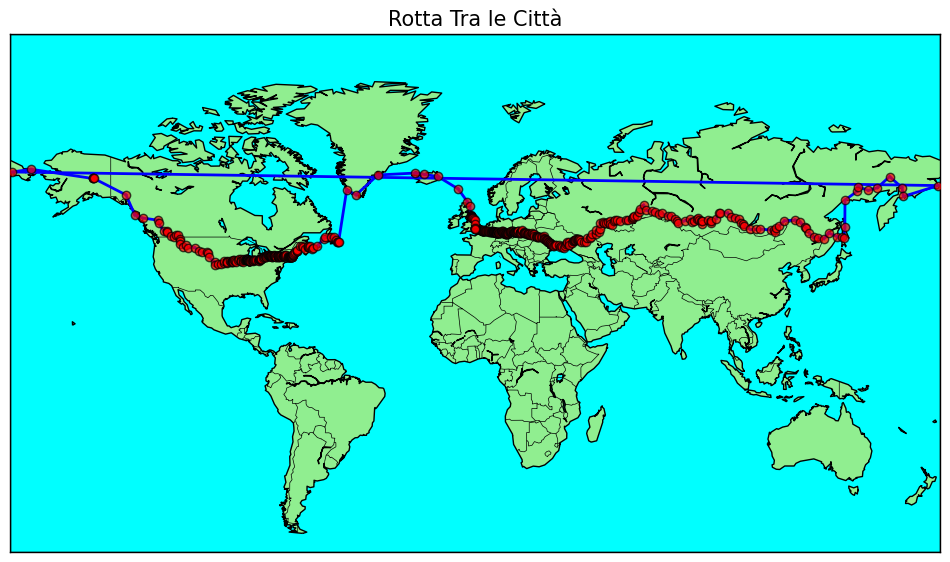

In [41]:
# Step 5: plotto il viaggio

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Carico i dati dal CSV "iterazioni"
df_iterations = pd.read_csv('iterazioni.csv')

# Creo la mappa
fig, ax = plt.subplots(figsize=(12, 8))

m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, resolution='c', ax=ax)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgreen', lake_color='aqua')

# Calcolo le coordinate delle città
x, y = m(df_iterations['border_lng'].values, df_iterations['border_lat'].values)

# Disegno le linee di rotta tra le città
for i in range(len(x) - 1):
    m.plot([x[i], x[i + 1]], [y[i], y[i + 1]], color='blue', linestyle='-', linewidth=2, zorder=2)

# Plotto le città come punti 
m.scatter(x, y, marker='o', color='red', zorder=5, edgecolor='k', alpha=0.7)

# Titolo e visualizzazione
plt.title('Rotta Tra le Città', fontsize=15)
plt.show()